In [1]:
to_train = false
save_fig = true
include("../example/test3/test3_nn.jl")
folder = "../example/test3/";
include("plot_training.jl");
using ModUtil: repeat_experiment
using ModTraj
using BasicInterpolators
using ModSMC
using Statistics
using StatsPlots, DataFrames
using ModDyn

using Plots
using LaTeXStrings
using Plots.PlotMeasures

gr()

default(titlefont = (12), legendfontsize=8, 
    guidefont = (11), 
    fg_legend = :transparent)

figsize=(350,250)
;

# 0. Resources

In [2]:
Sys.cpu_info()[1].model, nprocs()

("Intel(R) Core(TM) i7-8700 CPU @ 3.20GHz", 1)

# 1. Training results

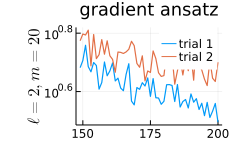

In [3]:
model_num = 2

start_idx = Int64(ceil(υ*train_step))
linewidth= 1.2

#fig_type = :err
fig_type = :var
#fig_type = :grad
yscale=:log10
#yscale=:identity
new_m_list = [20]

ℓm_list = [(ℓ, m) for ℓ in ℓ_list for m in new_m_list]
fig_grad  = Array{Any}(undef, length(ℓm_list))

for i = 1:length(ℓm_list) 
    ℓ, m = ℓm_list[i]
    ylabel = L"{\bf \ell = %$(ℓ), m = %$(m)}"
    if i == 1
        title = "gradient ansatz"
    else
        title = ""
    end
    fig_grad[i] = plot_error(m, ℓ, model_num, seed_list, exact_mean, folder, 
            fig_type=fig_type, start_idx = start_idx, ylabel=ylabel, title=title, 
            yscale=yscale, linewidth=linewidth)
end

xtic = [150,175,200]
fig_simu_grad = plot(fig_grad..., 
    size=(250,150), layout=(@layout grid(2,1)), 
    xticks=(xtic,xtic), left_margin=20px, right_margin=20px)
save_fig ? savefig(fig_simu_grad, "assets/test3_simu_grad_ansatz_"*string(fig_type)*".pdf") : nothing
fig_simu_grad

# 2. Flow lines

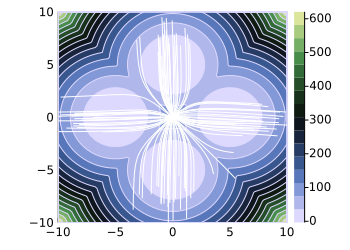

In [4]:
xmin = -10
xmax = 10
ymin = -10
ymax = 10

m = 20
ℓ = 2
model_num = 2
seed = 1

xc = range(xmin, stop=xmax, length=10^2)
yc = range(ymin, stop=ymax, length=10^2)
casename =  folder*@sprintf("case_%d_model_%d_%d_%d_%d_%d_%d_%d_training_data.jld2", 
        testcasenum, model_num, n, N, numsample_max, m, ℓ, seed)

flow = load(casename,  "flow")

T = 1.0
t_vec = Array(range(0,stop=1.0,length=Int64(ceil(T*50))+1))
unit_step = 5
num_particle = 100
traj_gpts = [U₀.sampler(i) for i in 1:num_particle]

fig_v = contour(xc, yc, (x,y)-> U₁.U(vcat([x,y], zeros(n-2))), fill=true, 
                color=:tofino, size=figsize, xlims=(xmin,xmax), ylims=(ymin,ymax),
                left_margin=20px, right_margin=20px)
plot_traj(num_particle, traj_gpts, flow, t_vec, unit_step)
save_fig ? savefig(fig_v, @sprintf("assets/test3_%d_%d_%d_%d.pdf",model_num,ℓ,m,seed)) : nothing

fig_v

# 3. Comparison

In [5]:
Random.seed!(1)
numsample = 10^3
numrepeat = 10;

U₀.sampler = j->gpts_sampler() #j->gpts[:,j]

s1 = 300
s2 = 30

K = 10
βlist = Array(range(0, stop=1.0, length=K+1))
τ = 0.1
fun_ais_10 = numsample->mean(map(j->ais_neal(U₀.sampler(j), n, U₀, U₁, K, βlist, τ)[1], 1:(numsample*s1)))
time_ais_10 = @elapsed data_ais_10_rep = repeat_experiment(fun_ais_10, numsample, numrepeat, gpts, gpts_sampler);

K = 100
βlist = Array(range(0, stop=1.0, length=K+1))
τ = 0.1
fun_ais_100 = numsample->mean(map(j->ais_neal(U₀.sampler(j), n, U₀, U₁, K, βlist, τ)[1], 1:(numsample*s2)))
time_ais_100 = @elapsed data_ais_100_rep = repeat_experiment(fun_ais_100, numsample, numrepeat, gpts, gpts_sampler);

#Ngd = 5*N # time-discretization; for gradient-flow only
Ngd = 20*N 
GDT = 2.0
Ωq = domain_ball(30);
flow_gd = generate_gradient_flow(U₁, GDT, Ωq);
fun_gd = numsample-> get_data_err_var(U₀, U₁, flow_gd, Ngd, numsample)[2]
time_gd = @elapsed data_gd_rep = repeat_experiment(fun_gd, numsample, numrepeat, gpts, gpts_sampler);

fun_nn = numsample -> get_data_err_var(U₀, U₁, flow, N, numsample)[2]
time_nn = @elapsed data_nn_rep = repeat_experiment(fun_nn, numsample, numrepeat, gpts, gpts_sampler);

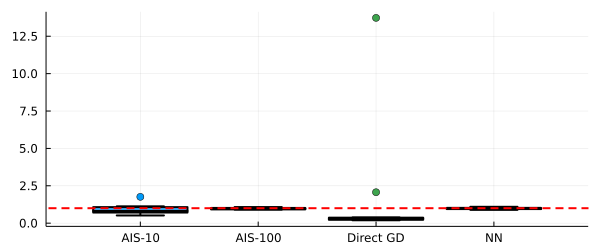

In [6]:
df = DataFrame(ais10 = data_ais_10_rep/exact_mean, 
    ais100 = data_ais_100_rep/exact_mean, 
    gd = data_gd_rep/exact_mean, 
    nn = data_nn_rep/exact_mean)
fig = @df df boxplot([:ais10, :ais100, :gd, :nn], 
    xticks = (1:1:5, ["AIS-10", "AIS-100", "Direct GD", "NN"]),
    fillalpha = 0.75, linewidth=2, label="", size=(600,250), outliers=true)
plot!(0:1:5, ones(6), linewidth=2, label="", color=:red, linestyle=:dash)
plot!(xlim=(0.2, 4.8))
save_fig ? savefig(fig, "assets/test3_compare.pdf") : nothing

fig

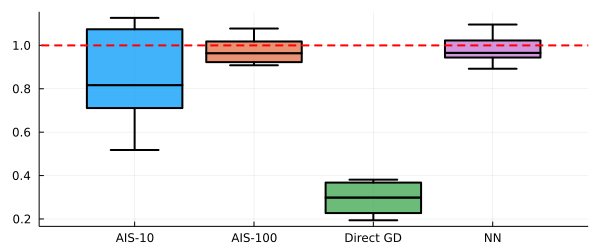

In [7]:
fig_no_outlier = @df df boxplot([:ais10, :ais100, :gd, :nn], 
    xticks = (1:1:5, ["AIS-10", "AIS-100", "Direct GD", "NN"]),
    fillalpha = 0.75, linewidth=2, label="", size=(600,250), outliers=false)
plot!(0:1:5, ones(6), linewidth=2, label="", color=:red, linestyle=:dash)
plot!(xlim=(0.2, 4.8))
save_fig ? savefig(fig_no_outlier, "assets/test3_compare_no_outlier.pdf") : nothing

fig_no_outlier

In [8]:
println(df)

10×4 DataFrame
 Row │ ais10    ais100   gd       nn      
     │ Float64  Float64  Float64  Float64 
─────┼────────────────────────────────────
   1 │   1.762    0.908   13.729    1.001
   2 │   0.852    0.948    0.327    0.943
   3 │   0.584    1.078    0.258    0.973
   4 │   0.518    0.911    0.276    0.892
   5 │   1.127    1.023    2.070    1.030
   6 │   0.951    1.002    0.194    0.958
   7 │   0.718    0.923    0.322    1.096
   8 │   1.115    0.980    0.381    0.947
   9 │   0.782    0.923    0.200    1.088
  10 │   0.709    1.050    0.217    0.943


In [9]:
println(time_ais_10)
println(time_ais_100)
println(time_gd)
println(time_nn)

362.195
352.404
1400.362
312.210


# 4. Estimate efficiency

## 4.1 NEIS

In [10]:
Random.seed!(1)

numsample_neis = 2*10^4

function estimate_neis_efficiency(; verbose=false)

    time_neis = @elapsed data, emp_m, emp_var = get_data_err_var(U₀, U₁, flow, N, numsample_neis)
    time_neis_per_sample = time_neis/length(data)
    var_neis = emp_var/exact_mean^2
    eff_neis = var_neis * time_neis_per_sample
    
    verbose ? @printf("mean %.2E\n", mean(data)/exact_mean) : nothing
    verbose ? @printf("efficiency %.2E\n", eff_neis) : nothing
    
    return time_neis, time_neis_per_sample, var_neis, eff_neis
    
end

estimate_neis_efficiency (generic function with 1 method)

In [11]:
eff_neis_vec = map(j->estimate_neis_efficiency(verbose=true)[4], 1:5)
print(eff_neis_vec)

mean 1.01E+00
efficiency 1.09E-01
mean 1.01E+00
efficiency 1.10E-01
mean 9.84E-01
efficiency 1.05E-01
mean 1.01E+00
efficiency 1.07E-01
mean 9.92E-01
efficiency 1.07E-01
[0.109, 0.110, 0.105, 0.107, 0.107]

## 4.2 AIS-100

In [12]:
import Statistics: std

K = 100
βlist = Array(range(0, stop=1.0, length=K+1))
τ = 0.1

numsample_ais = 2*10^5

function estimate_ais_efficiency(; verbose=true)
    time_ais = @elapsed estimate = map(j->ais_neal(U₀.sampler(j), n, U₀, U₁, K, βlist, τ)[1], 1:(numsample_ais))
    time_per_sample = time_ais/numsample_ais
    var_ais = std(estimate, corrected=false).^2/exact_mean^2
    eff_ais_100 = time_per_sample * var_ais
    
    verbose ? @printf("Mean is %.3f\n", mean(estimate)/exact_mean) : nothing
    verbose ? println(eff_ais_100) : nothing
    
    return time_ais, time_per_sample, var_ais, eff_ais_100
end

estimate_ais_efficiency (generic function with 1 method)

In [13]:
eff_ais_100 = map(j->estimate_ais_efficiency()[4], 1:5)

Mean is 1.023
0.111
Mean is 0.968
0.064
Mean is 0.949
0.053
Mean is 0.963
0.085
Mean is 1.014
0.126


5-element Vector{Float64}:
 0.111
 0.064
 0.053
 0.085
 0.126

In [14]:
err_std = 0.01
@printf("AIS takes around %.2f hours to achieve %.2E std error\n", 
    median(eff_ais_100)/err_std^2/(3600), err_std)

AIS takes around 0.24 hours to achieve 1.00E-02 std error


## 4.3 Cost ratio

In [15]:
minimum(eff_neis_vec)/maximum(eff_ais_100), maximum(eff_neis_vec)/minimum(eff_ais_100)

(0.835, 2.065)

In [16]:
median(eff_neis_vec)/median(eff_ais_100)

1.260